In [1]:
# based on https://github.com/hep-lbdl/OmniFold/GaussianExample.ipynb

# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import norm

import uproot
import pandas as pd

print(tf.__version__, uproot.__version__)

2024-09-11 21:31:13.508657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 21:31:13.516271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 21:31:13.524447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 21:31:13.526929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 21:31:13.534199: I tensorflow/core/platform/cpu_feature_guar

2.17.0 5.3.12


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1726108274.258565  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726108274.284148  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726108274.284300  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Loading numuCC Data

In [4]:
# MicroBooNE Run 1 nu_overlay with WC reconstruction

# Using half the file for prediction, and a small portion of the other half for fake data
# So, fake data is different because it uses no GENIE weights or uboone_tune weights

bdt_vars = [
    "nue_score",
    "numu_score",
    "numu_cc_flag"
]

eval_vars = [
    "truth_nuEnergy",
    "truth_nuPdg",
    "truth_isCC",
    "truth_vtxInside",
    "match_isFC",
    "match_completeness_energy",
    "truth_energyInside",
    "weight_cv",
    "weight_spline",
]

kine_vars = [
    "kine_reco_Enu",
]

pf_vars = [
    "reco_muonMomentum",
    "truth_muonMomentum",
]

f = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_bdt = f["T_BDTvars"].arrays(bdt_vars, library="pd")
f_eval = f["T_eval"].arrays(eval_vars, library="pd")
f_kine = f["T_KINEvars"].arrays(kine_vars, library="pd")
f_pfeval = f["T_PFeval"].arrays(pf_vars, library="pd")
overlay_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
overlay_df = pd.concat([f_bdt, f_eval, f_kine, f_pfeval], axis=1, sort=False)
del f
del f_bdt
del f_eval
del f_kine
del f_pfeval


In [5]:
costheta_vals = []
muonmomentum_vals = []
reco_muonmomentum_x = [x[0] for x in overlay_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_y = [x[1] for x in overlay_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_z = [x[2] for x in overlay_df["reco_muonMomentum"].to_numpy()]
reco_muonmomentum_t = [x[3] for x in overlay_df["reco_muonMomentum"].to_numpy()]
for i in range(len(reco_muonmomentum_x)):
    if reco_muonmomentum_t[i] < 105.66 / 1000.: # surprising that this happens for positive values, but I did find some events
        costheta_vals.append(-1)
        muonmomentum_vals.append(-1)
    else:
        costheta_vals.append(reco_muonmomentum_z[i] / np.sqrt(reco_muonmomentum_x[i]**2 + reco_muonmomentum_y[i]**2 + reco_muonmomentum_z[i]**2))
        muon_KE = reco_muonmomentum_t[i] * 1000. - 105.66
        muonmomentum_vals.append(np.sqrt(muon_KE**2 + 2 * muon_KE * 105.66))
overlay_df["reco_costheta"] = costheta_vals
overlay_df["reco_muon_momentum"] = muonmomentum_vals

overlay_df["true_muon_momentum_3"] = [_[3] * 1000. for _ in overlay_df["truth_muonMomentum"].to_numpy()]
overlay_df["true_muon_KE"] = overlay_df["true_muon_momentum_3"].to_numpy() - 105.66
overlay_df["true_muon_momentum"] = np.sqrt(overlay_df["true_muon_KE"]**2 + 2*overlay_df["true_muon_KE"] * 105.66)
overlay_df.loc[overlay_df["true_muon_momentum_3"] < 0, "true_muon_momentum"] = np.nan

sig_query = "match_completeness_energy>0.1*truth_energyInside and truth_nuPdg==14 and truth_isCC==1 and truth_vtxInside==1 and true_muon_momentum_3>0 and truth_nuEnergy<=4000 and truth_nuEnergy > 200 and true_muon_momentum > 0 and true_muon_momentum <= 2500"
sel_query = "numu_cc_flag >= 0 and numu_score > 0.9 and nue_score < 7 and reco_muon_momentum>0"
overlay_df["wc_numuCC_selected"] = overlay_df.eval(sel_query)
overlay_df["wc_numuCC_sig"] = overlay_df.eval(sig_query)

overlay_df["truth_vtxInside"] = overlay_df["truth_vtxInside"].astype(int)


In [6]:
split_index = int(len(overlay_df) * 0.5)
big_pred_df = overlay_df.iloc[:split_index, :]
big_fake_data_df = overlay_df.iloc[split_index:, :]
print(overlay_df.shape, big_pred_df.shape, big_fake_data_df.shape)

fake_data_POT = 1e20
big_fake_data_df = big_fake_data_df.sample(n=int(len(overlay_df) * fake_data_POT / overlay_POT))

print(big_fake_data_df.shape)

(581941, 22) (290970, 22) (290971, 22)
(81438, 22)


In [7]:
weight_cv_vals = big_pred_df["weight_cv"].to_numpy()
weight_spline_vals = big_pred_df["weight_spline"].to_numpy()
net_weights = []
for i in range(len(weight_cv_vals)):
    weight_cv = weight_cv_vals[i]
    weight_spline = weight_spline_vals[i]
    if not (0 < weight_cv < 30):
        weight_cv = 1
    net_weights.append(weight_cv * weight_spline * fake_data_POT / overlay_POT)

big_pred_df["net_weight"] = net_weights


/tmp/ipykernel_452574/3990479924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_pred_df["net_weight"] = net_weights


In [8]:
pred_df = big_pred_df[["wc_numuCC_selected", "wc_numuCC_sig", "truth_nuEnergy", "true_muon_momentum", "reco_muon_momentum", "truth_vtxInside", "net_weight"]]
fake_data_df = big_fake_data_df[["wc_numuCC_selected", "wc_numuCC_sig", "truth_nuEnergy", "true_muon_momentum", "reco_muon_momentum", "truth_vtxInside"]]
fake_data_no_truth_df = big_fake_data_df[["wc_numuCC_selected", "reco_muon_momentum"]]


# Plotting True and Reco

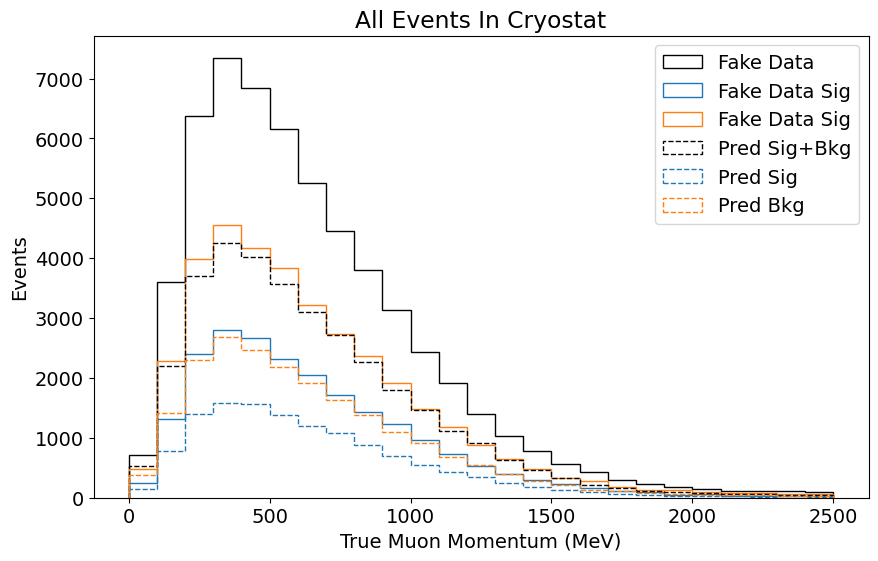

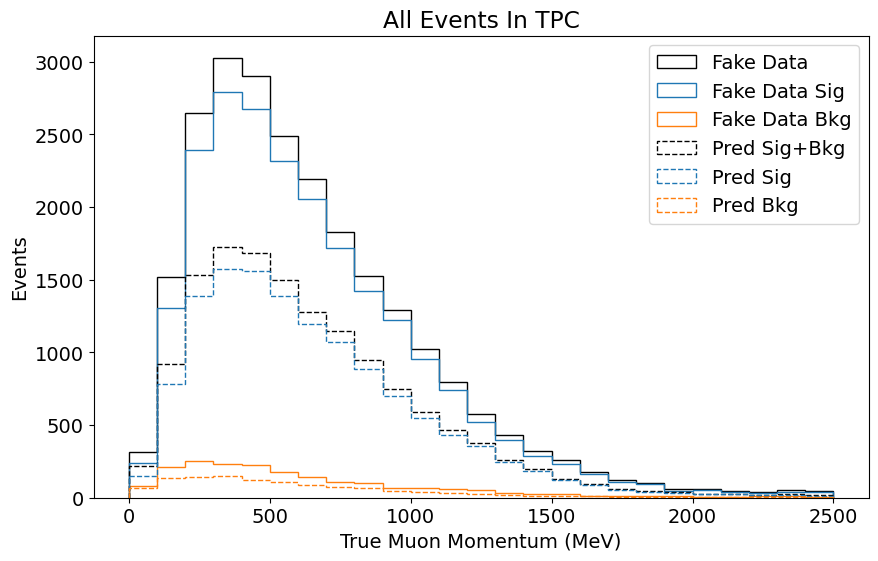

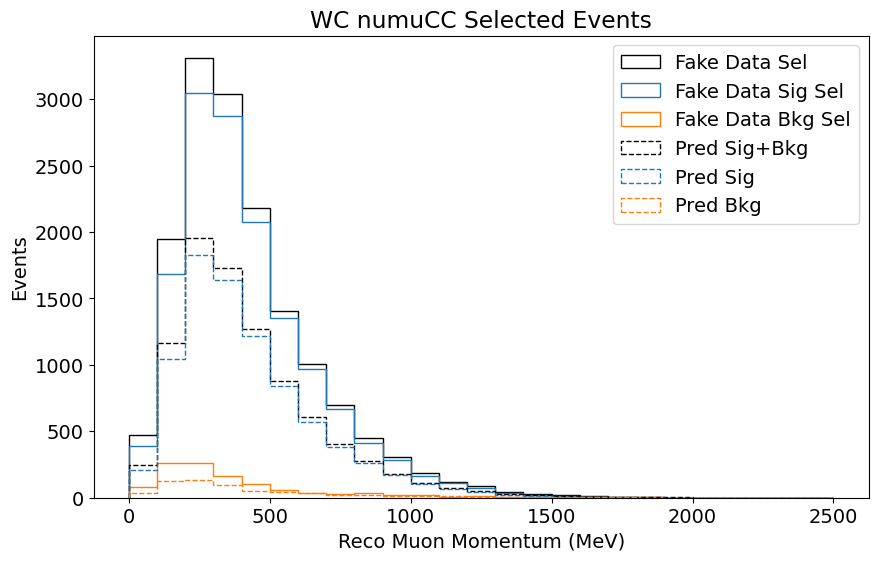

In [9]:
bins = np.linspace(0, 2500, 26)

pred_tpc_df = pred_df.query("truth_vtxInside==1")
fake_data_tpc_df = fake_data_df.query("truth_vtxInside==1")

pred_sig_df = pred_df.query("wc_numuCC_sig==1")
pred_bkg_df = pred_df.query("wc_numuCC_sig==0")
pred_sel_df = pred_df.query("wc_numuCC_selected==1")
pred_sig_sel_df = pred_sig_df.query("wc_numuCC_selected==1")
pred_bkg_sel_df = pred_bkg_df.query("wc_numuCC_selected==1")
fake_data_sig_df = fake_data_df.query("wc_numuCC_sig==1")
fake_data_bkg_df = fake_data_df.query("wc_numuCC_sig==0")
fake_data_sel_df = fake_data_df.query("wc_numuCC_selected==1")
fake_data_sig_sel_df = fake_data_sig_df.query("wc_numuCC_selected==1")
fake_data_bkg_sel_df = fake_data_bkg_df.query("wc_numuCC_selected==1")

pred_sig_tpc_df = pred_sig_df.query("truth_vtxInside==1")
pred_bkg_tpc_df = pred_bkg_df.query("truth_vtxInside==1")
pred_sel_tpc_df = pred_sel_df.query("truth_vtxInside==1")
pred_sig_sel_tpc_df = pred_sig_sel_df.query("truth_vtxInside==1")
pred_bkg_sel_tpc_df = pred_bkg_sel_df.query("truth_vtxInside==1")
fake_data_sig_tpc_df = fake_data_sig_df.query("truth_vtxInside==1")
fake_data_bkg_tpc_df = fake_data_bkg_df.query("truth_vtxInside==1")
fake_data_sel_tpc_df = fake_data_sel_df.query("truth_vtxInside==1")
fake_data_sig_sel_tpc_df = fake_data_sig_sel_df.query("truth_vtxInside==1")
fake_data_bkg_sel_tpc_df = fake_data_bkg_sel_df.query("truth_vtxInside==1")

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
plt.hist(fake_data_df["true_muon_momentum"], bins=bins, histtype="step", label="Fake Data", color="k")
plt.hist(fake_data_sig_df["true_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sig", color="C0")
plt.hist(fake_data_bkg_df["true_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sig", color="C1")

plt.hist(pred_df["true_muon_momentum"], weights=pred_df["net_weight"], bins=bins, histtype="step", label="Pred Sig+Bkg", color="k", ls="--")
plt.hist(pred_sig_df["true_muon_momentum"], weights=pred_sig_df["net_weight"], bins=bins, histtype="step", label="Pred Sig", color="C0", ls="--")
plt.hist(pred_bkg_df["true_muon_momentum"], weights=pred_bkg_df["net_weight"], bins=bins, histtype="step", label="Pred Bkg", color="C1", ls="--")
plt.xlabel("True Muon Momentum (MeV)")
plt.ylabel("Events")
plt.legend()
plt.title("All Events In Cryostat")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(fake_data_tpc_df["true_muon_momentum"], bins=bins, histtype="step", label="Fake Data", color="k")
plt.hist(fake_data_sig_tpc_df["true_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sig", color="C0")
plt.hist(fake_data_bkg_tpc_df["true_muon_momentum"], bins=bins, histtype="step", label="Fake Data Bkg", color="C1")
plt.hist(pred_tpc_df["true_muon_momentum"], weights=pred_tpc_df["net_weight"], bins=bins, histtype="step", label="Pred Sig+Bkg", color="k", ls="--")
plt.hist(pred_sig_tpc_df["true_muon_momentum"], weights=pred_sig_tpc_df["net_weight"], bins=bins, histtype="step", label="Pred Sig", color="C0", ls="--")
plt.hist(pred_bkg_tpc_df["true_muon_momentum"], weights=pred_bkg_tpc_df["net_weight"], bins=bins, histtype="step", label="Pred Bkg", color="C1", ls="--")
plt.xlabel("True Muon Momentum (MeV)")
plt.ylabel("Events")
plt.legend()
plt.title("All Events In TPC")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(fake_data_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sel", color="k")
plt.hist(fake_data_sig_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sig Sel", color="C0")
plt.hist(fake_data_bkg_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Bkg Sel", color="C1")
plt.hist(pred_sel_df["reco_muon_momentum"], weights=pred_sel_df["net_weight"], bins=bins, histtype="step", label="Pred Sig+Bkg", color="k", ls="--")
plt.hist(pred_sig_sel_df["reco_muon_momentum"], weights=pred_sig_sel_df["net_weight"], bins=bins, histtype="step", label="Pred Sig", color="C0", ls="--")
plt.hist(pred_bkg_sel_df["reco_muon_momentum"], weights=pred_bkg_sel_df["net_weight"], bins=bins, histtype="step", label="Pred Bkg", color="C1", ls="--")
plt.xlabel("Reco Muon Momentum (MeV)")
plt.ylabel("Events")
plt.legend()
plt.title("WC numuCC Selected Events")
plt.show()


# Subtracting The Background

In [10]:
# adding things here in a certain order to set up the loss as described in GaussianExample.ipynb

"""
x_data_and_MCback = np.concatenate([x_background[x_background!=dummyval],
                                    x_data_withback[x_data_withback!=dummyval],
                                    x_data_withback[x_data_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(x_background[x_background!=dummyval])),
                                    np.ones(len(x_data_withback[x_data_withback!=dummyval])),
                                    np.zeros(len(x_data_withback[x_data_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*w_back[x_background!=dummyval],
                                    np.ones(len(x_data_withback[x_data_withback!=dummyval])),
                                    np.ones(len(x_data_withback[x_data_withback!=dummyval]))])
"""

x_data_and_MCback = np.concatenate([
    pred_bkg_sel_df["reco_muon_momentum"],
    fake_data_sel_df["reco_muon_momentum"],
    fake_data_sel_df["reco_muon_momentum"],
])

y_data_and_MCback = np.concatenate([
    np.ones(len(pred_bkg_sel_df["reco_muon_momentum"])),
    np.ones(len(fake_data_sel_df["reco_muon_momentum"])),
    np.zeros(len(fake_data_sel_df["reco_muon_momentum"])),
])

W_data_and_MCback = np.concatenate([
    -1. * pred_bkg_sel_df["net_weight"],
    np.ones(len(fake_data_sel_df["reco_muon_momentum"])),
    np.ones(len(fake_data_sel_df["reco_muon_momentum"])),
])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)   

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)
    
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'],
              weighted_metrics=[]) #to silence an annoying warning ... could compute the weighted accuracy
model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=200,
          batch_size=10000,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=0)



I0000 00:00:1726108279.390019  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726108279.390161  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726108279.390248  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726108279.449099  452574 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.


In [11]:
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 

w_data = reweight(fake_data_df["reco_muon_momentum"])
w_data_sel = reweight(fake_data_sel_df["reco_muon_momentum"])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


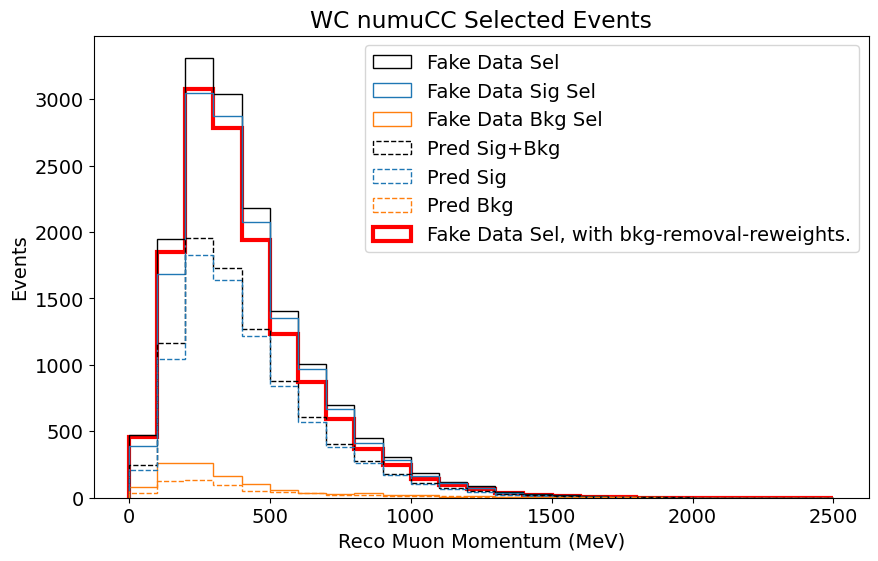

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(fake_data_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sel", color="k")
plt.hist(fake_data_sig_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Sig Sel", color="C0")
plt.hist(fake_data_bkg_sel_df["reco_muon_momentum"], bins=bins, histtype="step", label="Fake Data Bkg Sel", color="C1")
plt.hist(pred_sel_df["reco_muon_momentum"], weights=pred_sel_df["net_weight"], bins=bins, histtype="step", label="Pred Sig+Bkg", color="k", ls="--")
plt.hist(pred_sig_sel_df["reco_muon_momentum"], weights=pred_sig_sel_df["net_weight"], bins=bins, histtype="step", label="Pred Sig", color="C0", ls="--")
plt.hist(pred_bkg_sel_df["reco_muon_momentum"], weights=pred_bkg_sel_df["net_weight"], bins=bins, histtype="step", label="Pred Bkg", color="C1", ls="--")

plt.hist(fake_data_sel_df["reco_muon_momentum"], weights=w_data_sel, bins=bins, histtype="step", label="Fake Data Sel, with bkg-removal-reweights.", color="r", lw=3, zorder=-1)

plt.xlabel("Reco Muon Momentum (MeV)")
plt.ylabel("Events")
plt.legend()
plt.title("WC numuCC Selected Events")
plt.show()

# Unfolding

In [ ]:
iterations = 4

weights = np.empty(shape=(iterations, 2, len(pred_df["reco_muon_momentum"])))

weights_pull = np.ones(len(pred_df["reco_muon_momentum"]))
weights_push = np.ones(len(pred_df["reco_muon_momentum"]))


xvals_1 = np.concatenate((pred_df["reco_muon_momentum"], fake_data_df["reco_muon_momentum"]))
yvals_1 = np.concatenate((np.zeros(len(pred_df["reco_muon_momentum"])), np.ones(len(fake_data_df["reco_muon_momentum"]))))

xvals_2 = np.concatenate((pred_df["reco_muon_momentum"], pred_df["reco_muon_momentum"]))
yvals_2 = np.concatenate((np.zeros(len(pred_df["reco_muon_momentum"])), np.ones(len(pred_df["reco_muon_momentum"]))))



In [ ]:
# CONTINUE HERE

for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push*pred_sel_df["net_weight"], w_data))

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) 

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'],
                  weighted_metrics=[])
    model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=0)

    weights_pull = weights_push * reweight(x_sim) 
    
    weights_pull[x_sim==dummyval] = 1. 

    

    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((w_synth, weights_pull*w_synth))

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'],
                  weighted_metrics=[])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=2000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=0)

    weights_push = reweight(x_gen)

    weights_push[x_gen==dummyval] = 1. 
    

    weights[i, 1:2, :] = weights_push